# Imports

In [10]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from photutils.detection import DAOStarFinder
from scipy.optimize import curve_fit

plt.rcParams.update({'font.size': 12})

# Load and view image

In [11]:
def open_fits_file(file_path):
    with fits.open(file_path, do_not_scale_image_data=True) as hdul:
        primary_hdu = hdul[0]
        image_data = primary_hdu.data

        bscale = primary_hdu.header.get('BSCALE', 1.0)
        bzero = primary_hdu.header.get('BZERO', 0.0)
        image_data = bscale * image_data + bzero
    return image_data

def get_data(image_path: str):
    """
    Takes the path of the image in FITS format and extracts the data
    """
    data = fits.getdata(image_path)
    return data

def show_data(data, vmin: int = 0.0001, vmax: int = 1000):
    """
    Takes in the data from the FITS image and shows you the image.
    Play around with the vmin and vmax to get the best looking image.
    """
    plt.figure()
    plt.imshow(data, cmap = 'inferno', aspect='auto', norm = LogNorm(vmin=vmin, vmax=vmax),origin = 'lower')
    cb = plt.colorbar()
    cb.set_label(label='Intensity [ADU]', size=20)

# Centering the Cells

In [12]:
def sub_image(x_coord, y_coord, data, boxsize:int = 100):
    """
    Create a sub-image of size {boxsize}x{boxsize} around the reference star but not necessarily centered on it.
    """

    sub_im = data[y_coord - boxsize: y_coord + boxsize+1, x_coord - boxsize: x_coord + boxsize+1]
    return sub_im

def find_exact_center(sub_img):
    """
    Finds the exact coordinates of the center (brightest spot) of each cell using the sub-image around it.
    Returns two arrays:
    - stack: contains the distribution of the total intensity in the x and y signals
    - center_coords: containts the coords of the exact center of each cell
    """
    stack_x = np.zeros(sub_img.shape[1])
    stack_y = np.zeros(sub_img.shape[0])
    
    for j in range(sub_img.shape[0])[-10 + sub_img.shape[0]//2:10 + sub_img.shape[0]//2]:
        stack_x += sub_img[j,:]
        stack_y += sub_img[:,j]
    
    x_cent = np.where(stack_x==max(stack_x))[0][0]
    y_cent = np.where(stack_y==max(stack_y))[0][0]
    center_coords = np.array([x_cent,y_cent])
    
    return [stack_x, stack_y], center_coords

# Aperture Photometry

This is what gets you the background subtracted signal at each cell

In [13]:
def std_radius(stacks, center_coords, boxsize: int = 100):
    """ Returns the standard deviation of the radius using Gaussian fitting """
    def gaus(x, a, x0, sigma):
        """ Function for a Gaussian curve. """
        return a * np.exp(-(x - x0)**2 / (2 * sigma**2))
    axis = np.arange(0, 2 * boxsize + 1)
    try:
        popt_x, pcov_x = curve_fit(gaus, axis, stacks[0], p0=[max(stacks[0]), center_coords[0], 10], maxfev=20000)
        popt_y, pcov_y = curve_fit(gaus, axis, stacks[1], p0=[max(stacks[1]), center_coords[1], 10], maxfev=20000)
    except RuntimeError as e:
        print(f"Error fitting Gaussian: {e}")
        return None
    std_rad = np.sqrt((popt_x[2]**2) + (popt_y[2]**2))
    
    if std_rad > (boxsize/2):
        # print("Standard deviation is too large, check the data.")
        std_rad = boxsize/2

    return np.round(std_rad)


def aperture(sub_image, std: float):
    """
    Create the aperture around the centered reference star, needs to be multiplied by the centered sub-image.
    """
    
    # compute the radius once for the entire sub-image
    i, j = np.indices(sub_image.shape)
    dist = (i - len(sub_image[0])/2)**2 + (j - len(sub_image[1])/2)**2
    
    # create the boolean mask using numpy operations
    mask = dist <= (1.5*std)**2
    
    # use the boolean mask to create the masked array
    masked = np.zeros_like(sub_image)
    masked[mask] = 1
    
    return masked

def annulus(sub_image, std: float):
    """
    Create the annulus around the centered reference star, needs to be multiplied by the centered sub-image.
    """
    
    # compute the radius once for the entire sub-image
    i, j = np.indices(sub_image.shape)
    radius = (i - len(sub_image[0])/2)**2 + (j - len(sub_image[1])/2)**2
    # print("annulus")
    # print(i, j, radius)
    
    # create the boolean mask using numpy operations
    mask = (radius >= (2.5*std)**2) & (radius <= (4*std)**2)
    # print(mask, std)
    
    # use the boolean mask to create the masked array
    masked = np.zeros_like(sub_image)
    masked[mask] = 1
    
    return masked

def flux_calc(centered_sub_img, std_rad: float):
    """
    Returns the flux of the centered sub-image using the annulus and aperture
    """
    N = np.count_nonzero(annulus(centered_sub_img, std_rad))
    bg = np.sum(centered_sub_img * annulus(centered_sub_img, std_rad)) / N if N != 0 else 0.001
    flux = np.sum((centered_sub_img - bg) * aperture(centered_sub_img, std_rad))
    # if flux <= 0:
    #     print('a')
    #     show_data(centered_sub_img, vmin = 100, vmax = 10000)
    return flux

def view_aperture_annulus(sub_im_cent, std_rad: float, vmin: int = 0.0001, vmax: int = 1000):
    """
    Shows the aperture and annulus created around the center of each cell.
    """
    plt.figure()
    plt.imshow(sub_im_cent * aperture(sub_im_cent,std_rad) + sub_im_cent * annulus(sub_im_cent,std_rad),
               cmap = 'inferno', aspect='auto', norm = LogNorm(vmin=vmin, vmax=vmax),origin = 'lower')
    plt.title('Masked Target Star')
    cb = plt.colorbar()
    cb.set_label(label = 'Intensity [ADU]', size=20)

def flux_uncertainty(sub_im_cent, std: float, flux: float):
    """
    Returns the uncertainty in the flux of the object
    """
    app = sub_im_cent * aperture(sub_im_cent, std)
    ann = sub_im_cent * annulus(sub_im_cent, std)

    aperture_pixels = np.count_nonzero(app)
    ann_1d = ann[ann != 0]
    ann_std = np.std(ann_1d)

    # # Adjust standard deviation if the distribution is uniform
    # if np.isnan(ann_std):
    #     ann_std = np.sqrt(np.mean((ann_1d - np.mean(ann_1d))**2)) + ann_range
    if np.isnan(ann_std):
        ann_std = 0.01

    bg_unc = np.sqrt(aperture_pixels * ann_std)
    source_unc = np.sqrt(flux / 4)
    flux_unc = np.sqrt(bg_unc**2 + source_unc**2)
    # print(f'Flux uncertainty = {flux_unc}, Background uncertainty = {bg_unc}, Source uncertainty = {source_unc}')
    # print(f'Aperture pixels = {aperture_pixels}, Annulus std = {ann_std}')

    return flux_unc


# def signal_to_noise(flux: float, flux_uncertainty: float):
#     """
#     Returns the signal to noise ratio for an object
#     """

#     s2n_ratio = flux/flux_uncertainty

#     return s2n_ratio

def signal_to_noise(N_star, t, p, R = 1, S_sky = 1):
    numerator = N_star * t
    denominator = np.sqrt(N_star * t + S_sky * p * t + p * R**2)
    SNR = numerator / denominator
    return SNR


# DAO Starfinder

This finds the *approximate* centers of your cells (provided there is no bright glare).

Will probably need to install photoutils before you can use this

In [31]:
def cell_finder(data, threshold: int = 110, fwhm: int = 5, 
                x_min: int = 0, x_max: int = 9576, y_min: int = 0, y_max: int = 6388,
                sharplo=0.2, sharphi=1.0, min_size=4, max_intensity=1000):
    """
    Finds the centers of each of your cells and outputs them in a list with each entry formatted as [x_coord, y_coord]
    You'll likely have to play around with the parameters of this function to get the best results.
    
    Parameters:
    - data: the data extracted from your FITS image
    - threshold: this forms the lower limit of the signals, all signals above this with the appropriate full-width half-max 
    (set by 'fwhm') will be detected by the algorithm
    - fwhm: full-width half-max of the bright spot
    - x_min: used for cropping the image from the left
    - x_max: used for cropping the image from the right
    - y_min: used for cropping the image from the bottom
    - y_max: used for cropping the image from the top
    
    The image size has been defaulted to the size outputted by the QHY600 camera.
    Feel free to change this if you decide to use Hamamatsu instead.
    """
    daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold, sharplo=sharplo, sharphi=sharphi) 
    cells = daofind(data[x_min:x_max, y_min:y_max])
    
    coords = []
    for i in range(len(cells['xcentroid'])):
        # if coord_check([cells['xcentroid'][i], cells['ycentroid'][i]], coords, boxsize):
        #     coords.append([int(cells['xcentroid'][i]+x_min),int(cells['ycentroid'][i]+y_min)])
        if cells['npix'][i] >= min_size and cells['peak'][i] <= max_intensity:
            coords.append([int(cells['xcentroid'][i]+x_min), int(cells['ycentroid'][i]+y_min)])
    
    print(f'Number of cells detected = {len(coords)}')
    
    return coords

def coord_check(coord, array, boxsize):
    for i in array:
        dist = np.sqrt((i[0]-coord[0])**2 + (i[1]-coord[1])**2)
        if 2*boxsize >= dist:
            return False
    return True

# def cell_finder(data, threshold: int = 110, fwhm: int = 5, 
#                 x_min: int = 0, x_max: int = 9576, y_min: int = 0, y_max: int = 6388,
#                 sharplo=0.2, sharphi=1.0, min_size=4, max_intensity=1000, boxsize=40):
#     """
#     Finds the centers of each of your cells and outputs them in a list with each entry formatted as [x_coord, y_coord, flux]
#     The detections that overlap will prioritize the one with higher flux.
#     """
#     daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold, sharplo=sharplo, sharphi=sharphi) 
#     cells = daofind(data[x_min:x_max, y_min:y_max])
    
#     coords_fluxes = []
#     for i in range(len(cells['xcentroid'])):
#         # Calculate the flux for the current detection
#         x_centroid = int(cells['xcentroid'][i] + x_min)
#         y_centroid = int(cells['ycentroid'][i] + y_min)
#         sub_im = data[y_centroid-boxsize:y_centroid+boxsize, x_centroid-boxsize:x_centroid+boxsize]
        
#         flux = flux_calc(sub_im, std_radius(sub_im, [boxsize, boxsize], boxsize))
        
#         # Only add detections that pass the size and intensity check
#         if cells['npix'][i] >= min_size and cells['peak'][i] <= max_intensity:
#             coords_fluxes = prioritize_flux([x_centroid, y_centroid, flux], coords_fluxes, boxsize)
    
#     # Extract only the coordinates (without flux) for further processing
#     coords = [[coord[0], coord[1]] for coord in coords_fluxes]
    
#     print(f'Number of cells detected = {len(coords)}')
#     return coords

# def prioritize_flux(new_coord_flux, existing_coords_fluxes, boxsize):
#     """
#     Adds new detection based on flux. If an overlap is found, the detection with the higher flux is kept.
    
#     Parameters:
#     - new_coord_flux: [x_coord, y_coord, flux] for the new detection
#     - existing_coords_fluxes: List of existing detections with their [x_coord, y_coord, flux]
#     - boxsize: Size used for determining overlap
    
#     Returns:
#     - Updated list of detections with the higher-flux detections retained
#     """
#     x_new, y_new, flux_new = new_coord_flux
    
#     for i, (x_old, y_old, flux_old) in enumerate(existing_coords_fluxes):
#         dist = np.sqrt((x_old - x_new) ** 2 + (y_old - y_new) ** 2)
        
#         if dist <= 2 * boxsize:
#             # Overlap detected, prioritize the detection with higher flux
#             if flux_new > flux_old:
#                 existing_coords_fluxes[i] = new_coord_flux  # Replace the old detection with the new one
#             return existing_coords_fluxes  # Exit after handling overlap
    
#     # If no overlap, simply add the new detection
#     existing_coords_fluxes.append(new_coord_flux)
#     return existing_coords_fluxes


def show_cells(data, coords, vmin: int = 0.0001, vmax: int = 1000):
    """
    Shows you the image and where the cells identified by the algorithm are located.
    Play around with the vmin and vmax to get the best looking image.
    """
    x_coords = [i[0] for i in coords]
    y_coords = [i[1] for i in coords]
    
    plt.figure()
    plt.imshow(data, cmap='inferno', aspect='auto', norm=LogNorm(vmin=vmin, vmax=vmax), origin='lower')
    cb = plt.colorbar()
    cb.set_label(label='Intensity [ADU]', size=20)
    plt.scatter(x_coords, y_coords, s=50, color='b', facecolor='none')
    
    for idx, (x, y) in enumerate(coords):
        plt.text(x + 20, y+10, str(idx + 1), color='blue', fontsize=8, ha='left', va='center')
    
    plt.show()
    

# Example Code

### Test

In [20]:
# Define image path
image_path = '../images/experiment 9/515LP_LANO/with_signal_1.fits'

# Load in the data
data = open_fits_file(image_path)
print(data)

[[  9  11   4 ...   9   8  12]
 [  9  20  13 ...   9  11  10]
 [  4  16  19 ...   1   7  12]
 ...
 [  9   7  10 ...   4   0   4]
 [ 12  15   0 ...  -6   1   8]
 [  3  16  14 ...   7   1 -20]]


Number of cells detected = 0


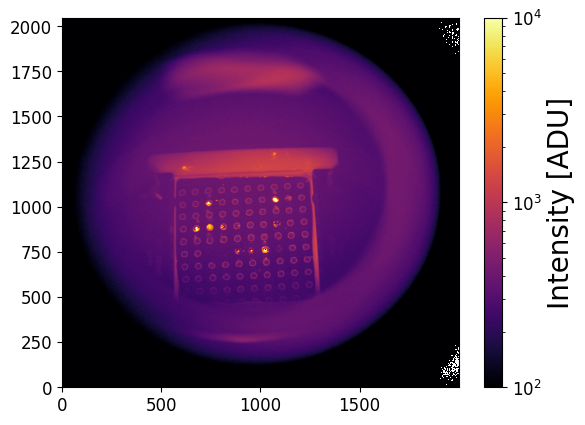

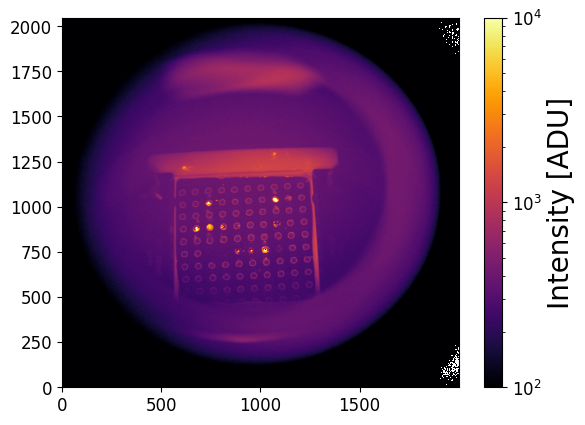

In [21]:
# View image if needed
show_data(data, vmin = 100, vmax = 10000)

# Find the approximate positions of the cells
coords = cell_finder(data, threshold = 10000, fwhm = 5, x_min = 0, x_max = 9576, y_min = 0, y_max = 6388)

# View cell locations to confirm the code works as expected
show_cells(data, coords, vmin = 100, vmax = 10000)

In [22]:
# Initialize empty lists to store values from each cell
fluxes = []
uncertainties = []
s2n_ratios = []

# This essentially determines the size of the sub-image, feel free to change if needed
boxsize = 35
count = 0
# Start a for-loop to do the analysis for each cell individually
for i in coords:
    x_coord, y_coord = i
    
    # Make the sub-image centered at the approximate center coords found by the algorithm
    sub_im = sub_image(x_coord, y_coord, data, boxsize)
    
    # Find the actual coordinates of the center within the sub-image
    stacks, center_coords = find_exact_center(sub_im)

    # Recalculate the coords of the center to make them be at the center of the sub-image
    cent_x_coord, cent_y_coord = center_coords - boxsize + i
    
    # Remake the sub-image with the new center coords
    cent_sub_img = sub_image(cent_x_coord, cent_y_coord, data, boxsize)

    # Calculate the radius factor needed for the aperture and annulus
    std_rad = std_radius(stacks, center_coords, boxsize)

    # View the aperture and annulus if needed    
    show_data(cent_sub_img, vmin = 100, vmax = 10000)
    view_aperture_annulus(cent_sub_img, std_rad, vmin = 100, vmax = 10000)
    
    # Calculate the background subtracted flux of the cell
    flux = flux_calc(cent_sub_img, std_rad)
    # Calculate the uncertainty in the flux
    flux_unc = flux_uncertainty(cent_sub_img, std_rad, flux)

    # if flux <= 0 or np.isnan(flux):
    #     print(f'Flux = {flux}, count = {count}')
    #     show_data(cent_sub_img, vmin = 100, vmax = 10000)
    #     view_aperture_annulus(cent_sub_img, std_rad, vmin = 100, vmax = 10000)
        
    # if flux_unc <= 0 or np.isnan(flux_unc):
    #     print(f'Flux uncertainty = {flux_unc}, count = {count}')
    #     show_data(cent_sub_img, vmin = 100, vmax = 10000)
    #     view_aperture_annulus(cent_sub_img, std_rad, vmin = 100, vmax = 10000)
    
    # Calculate the signal-to-noise ratio of the cell
    s2n = signal_to_noise(flux, flux_unc)
    
    # Append all the calculated values to their respected lists
    fluxes.append(flux)
    uncertainties.append(flux_unc)
    s2n_ratios.append(s2n)

    count += 1
    
print(s2n_ratios)

[]


### Small Ximea Camera

In [40]:
# Define image path
image_path = '../images/experiment 12/small ximea camera/signal_200ms_14dB_1.fits'

# Load in the datR
# load_image(image_path, threshold = 30, vmin = 10, vmax = 10000, show = True)

threshold = 100
vmin = 10
vmax = 1000

data = open_fits_file(image_path)
# coords = cell_finder(data, threshold = 100, fwhm = 1, x_min = 0, x_max = 2000, y_min = 0, y_max = 2000, min_size=10, max_intensity=100)
# print(coords)
coords = [[1004, 334], [979, 995], [730, 857], [735, 985], [710, 1117], [491, 446]]
# show_cells(data, coords, vmin = 10, vmax = 1000)

fluxes = []
uncertainties = []
s2n_ratios = []

boxsize = 40
count = 1
for i in coords:
    x_coord, y_coord = i
    sub_im = sub_image(x_coord, y_coord, data, boxsize)
    # show_data(sub_im, vmin=vmin, vmax=vmax)
    stacks, center_coords = find_exact_center(sub_im)

    # Calculate the flux for this sub-image
    flux = flux_calc(sub_im, std_rad)  # Make sure std_rad is calculated appropriately
    # The rest of your parameters
    S_sky = 10  # Assuming you are ignoring sky count in a dark room, set this to 0 if not needed
    p = sub_im.size  # Number of pixels in the aperture
    R = 1  # Read noise (you need to provide this or calculate it)
    t = 0.2  # Exposure time in seconds
    # Calculate N_star (count rate in e-/s) by dividing flux by exposure time
    N_star = flux / t  # Count rate from the object
    
    # Calculate the signal-to-noise ratio
    s2n = signal_to_noise(N_star, t, p, R, S_sky)
    s2n_ratios.append(s2n)

    print(f'Cell {count}:')
    print(f'Flux = {flux}, Flux uncertainty = {flux_unc}')
    print(f'Signal to noise ratio = {s2n}')
    print('---------')
    count += 1


Cell 1:
Flux = 36036.60624071323, Flux uncertainty = 157.14645738604426
Signal to noise ratio = 152.66513463699096
---------
Cell 2:
Flux = 24329.077265973257, Flux uncertainty = 157.14645738604426
Signal to noise ratio = 115.96841041484092
---------
Cell 3:
Flux = 6302.350668647838, Flux uncertainty = 157.14645738604426
Signal to noise ratio = 39.09653536983468
---------
Cell 4:
Flux = 19578.585438335813, Flux uncertainty = 157.14645738604426
Signal to noise ratio = 98.80920250818376
---------
Cell 5:
Flux = 28034.965824665684, Flux uncertainty = 157.14645738604426
Signal to noise ratio = 128.33912385342998
---------
Cell 6:
Flux = 25613.956909361063, Flux uncertainty = 157.14645738604426
Signal to noise ratio = 120.34890999943927
---------


### Large Ximea Camera

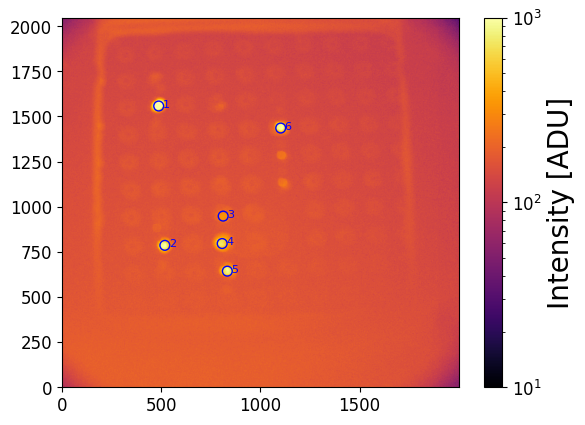

In [34]:
image_path = '../images/experiment 12/large ximea camera/signal_200ms_0dB_2.fits'

vmin = 10
vmax = 1000
boxsize = 40
read_noise = 10
data = open_fits_file(image_path)

# auto detection
# coords = cell_finder(data, threshold = 120, fwhm = 0.1, x_min = 0, x_max = 2000, y_min = 0, y_max = 2000, min_size=10, max_intensity=900)
# print(coords)

# manual detection
coords = [[487, 1558], [518, 786], [812, 948], [807, 796], [833, 643], [1102, 1436]]
show_cells(data, coords, vmin = vmin, vmax = vmax)

Cell 1:
Flux = 2170593.7979197623, Flux uncertainty = 157.14645738604426
Signal to noise ratio = 263.6233281602167
---------
Cell 2:
Flux = 1208010.0163447252, Flux uncertainty = 157.14645738604426
Signal to noise ratio = 147.76824881153644
---------
Cell 3:
Flux = 261459.43387815752, Flux uncertainty = 157.14645738604426
Signal to noise ratio = 32.21160915699748
---------
Cell 4:
Flux = 844777.4442793464, Flux uncertainty = 157.14645738604426
Signal to noise ratio = 103.61826891098109
---------
Cell 5:
Flux = 1123098.2585438336, Flux uncertainty = 157.14645738604426
Signal to noise ratio = 137.46888659871533
---------
Cell 6:
Flux = 1269812.2407132243, Flux uncertainty = 157.14645738604426
Signal to noise ratio = 155.25635503086113
---------


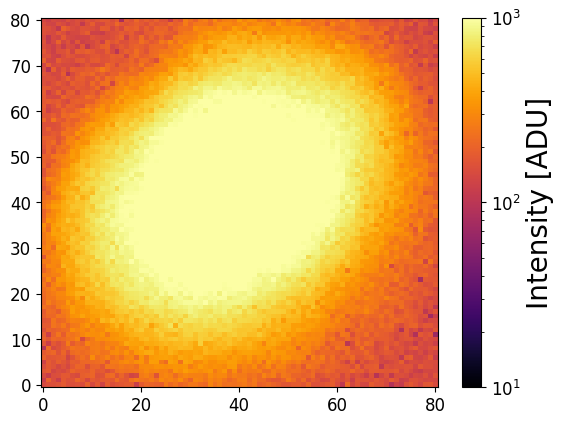

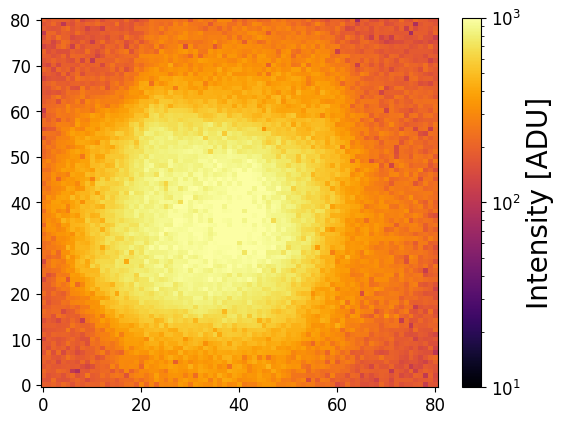

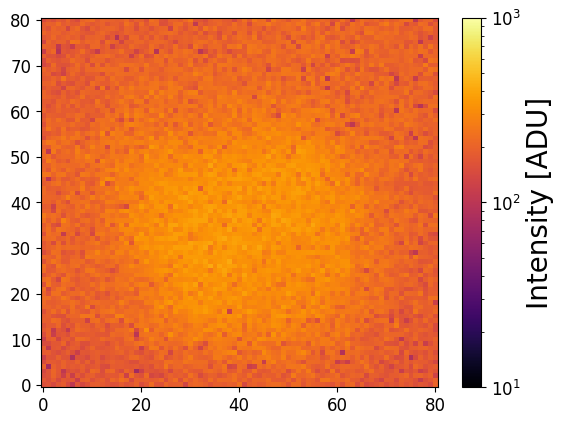

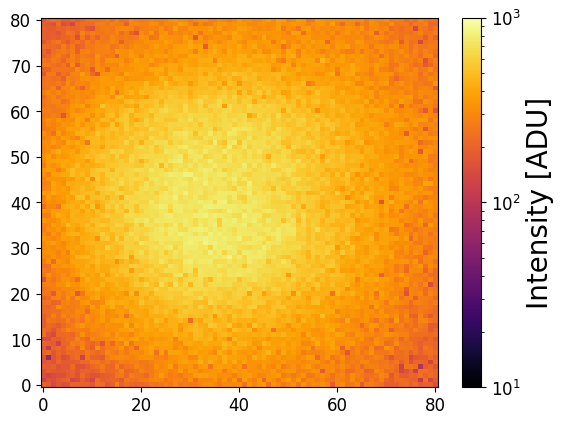

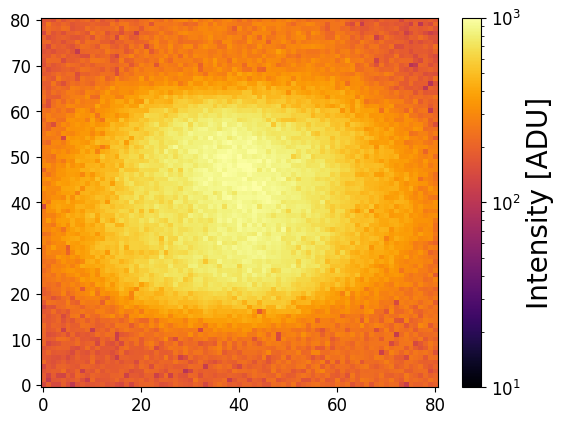

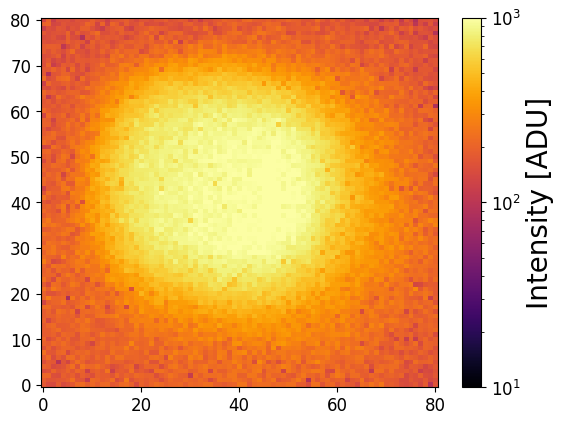

In [37]:
fluxes = []
uncertainties = []
s2n_ratios = []

boxsize = 40
count = 1
for i in coords:
    x_coord, y_coord = i
    sub_im = sub_image(x_coord, y_coord, data, boxsize)
    show_data(sub_im, vmin=vmin, vmax=vmax)
    stacks, center_coords = find_exact_center(sub_im)

    # Calculate the flux for this sub-image
    flux = flux_calc(sub_im, std_rad)  # Make sure std_rad is calculated appropriately
    # The rest of your parameters
    S_sky = 10  # Assuming you are ignoring sky count in a dark room, set this to 0 if not needed
    p = sub_im.size  # Number of pixels in the aperture
    R = 100  # Read noise (you need to provide this or calculate it)
    t = 0.2  # Exposure time in seconds
    # Calculate N_star (count rate in e-/s) by dividing flux by exposure time
    N_star = flux / t  # Count rate from the object
    
    

    # Calculate the signal-to-noise ratio
    s2n = signal_to_noise(N_star, t, p, R, S_sky)
    s2n_ratios.append(s2n)

    print(f'Cell {count}:')
    print(f'Flux = {flux}, Flux uncertainty = {flux_unc}')
    print(f'Signal to noise ratio = {s2n}')
    print('---------')
    count += 1
